# Autoencoders and GANs

Jupyter notebook following chapter 17 of *Hands on Machine Learning, Aurélien Géron.*

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

## Autoencoders

Autoencoders learn to copy inputs to outputs. Rather than learning to simply copy the input to the output, constraints or noise is added so they must learn to represent the data through learned patterns.

Below is the structure of an autoencoder. The data is mapped to the latent space (red) by the encoder (blue) and is reconstructed by the decoder (yellow):

![Autoencoder](resources/autoencoder.png)

It is similar to a normal neural network, except the number of input neurons must equal the number of outputs. The encoder part of the network maps the input data down to some lower-dimension latent space. The decoder then maps this latent space back to the original higher-dimension space. 

The output is called the reconstruction as it tries to reconstruct the lower-dimension data. It does this by minimising a cost function which peanalises the model when outputs are different to inputs.


### Dimensionality reduction with autoencoders

Because the latent space has a lower dimensionality than the input it is said to be undercomplete. It cannot represent the input exactly so it must find the best way to represent it, finding the most identifying patterns.

Using an undercomplete autoencoder with linear activation and mean squared error (MSE) as the cost function we would end up performing principle component analysis (PCA).

We shall use this method to reduce 3 dimensions of the iris dataset down to 2.

In [101]:
# iris = np.array(datasets.load_iris())
iris = datasets.load_iris()

X = iris.data[:,:3]
y = iris.target

In [114]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer='sgd')

It is simply a densly connected 2-layer MLP that takes an input with shape 3 and maps to an output with shape 2. Both layers have the linear activation function and we compile the model with MSE loss and SGD optimisation.

Now lets train this on the iris dataset:

In [115]:
history = autoencoder.fit(X, X, epochs=20)

Epoch 1/20
5/5 [==============================] - 0s 3ms/step - loss: 2.8922
Epoch 2/20
5/5 [==============================] - 0s 2ms/step - loss: 0.6443
Epoch 3/20
5/5 [==============================] - 0s 2ms/step - loss: 0.5583
Epoch 4/20
5/5 [==============================] - 0s 2ms/step - loss: 0.4951
Epoch 5/20
5/5 [==============================] - 0s 2ms/step - loss: 0.4472
Epoch 6/20
5/5 [==============================] - 0s 2ms/step - loss: 0.4018
Epoch 7/20
5/5 [==============================] - 0s 2ms/step - loss: 0.3665
Epoch 8/20
5/5 [==============================] - 0s 3ms/step - loss: 0.3326
Epoch 9/20
5/5 [==============================] - 0s 2ms/step - loss: 0.3029
Epoch 10/20
5/5 [==============================] - 0s 1ms/step - loss: 0.2753
Epoch 11/20
5/5 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 12/20
5/5 [==============================] - 0s 3ms/step - loss: 0.2355
Epoch 13/20
5/5 [==============================] - 0s 2ms/step - loss: 0.

Now we can make predictions of the 2d representation using the encoder:

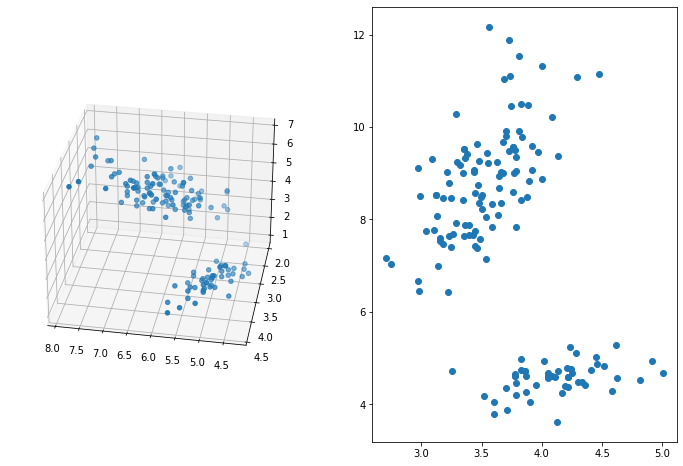

In [143]:
codings = encoder.predict(X)

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(30, 100)
ax.scatter(X[:,0], X[:,1], X[:,2])

ax = fig.add_subplot(1, 2, 2)
ax.scatter(codings[:,0], codings[:,1])

plt.show()

As we can see it has produced a 2d representation that seems to have maximised the variance - just like PCA!

### Stacked autoencoders

Above we have implemented a simple 2-layer autoencoder (1-layer encoder, 2-layer decoder). 

Just like other neural networks we can have many hidden layers to each. This is called a stacked autoencoder and is able to learn much more complex representations.

We shall train a stacked autoencoder to reproduce images from the MNIST dataset:

In [3]:
mnist = np.array(keras.datasets.mnist.load_data(path="mnist.npz"))

# seperate train and test X and y
train,   test    = mnist[0], mnist[1]
X_train, y_train = train[0], train[1]
X_test,  y_test  = test[0],  test[1] 

# create a validation set for training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# normalise images
X_train = X_train.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255


In [8]:
rows = X_train.shape[1] #28
cols = X_train.shape[2] #28

# input --> (rows,cols) --> flatten --> (rows*cols) --> dense --> (100) --> dense --> (30) = encoded output
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[rows,cols]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

# encoded input --> (30) --> Dense --> (100) -- Dense --> (rows*cols) --> Reshape --> (rows,cols) = reconstructed output            
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(rows*cols, activation='sigmoid'),
    keras.layers.Reshape([rows,cols])
])

# input --> ENCODER --> encoded --> DECODER --> reconstructed output
stacked_autoencoder = keras.models.Sequential([stacked_encoder, stacked_decoder])

# compile with binary crossentropy and evaluate binary accuracy (as values are now 0-1), optimising with SGD
stacked_autoencoder.compile(loss='binary_crossentropy', 
                            # optimizer=keras.optimizers.SGD(lr=1.5),
                            optimizer=keras.optimizers.SGD(learning_rate=1.5),
                            metrics=['binary_accuracy'])

stacked_autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 30)                81530     
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


Now we can train the model using the training data and validating with the validation set:

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = stacked_autoencoder.fit(X_train, X_train,
                                  validation_data=(X_val, X_val),
                                  epochs=20, callbacks=[callback])

Epoch 1/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1174 - binary_accuracy: 0.8114 - val_loss: 0.1161 - val_binary_accuracy: 0.8114
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1146 - binary_accuracy: 0.8117 - val_loss: 0.1139 - val_binary_accuracy: 0.8114
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1125 - binary_accuracy: 0.8118 - val_loss: 0.1123 - val_binary_accuracy: 0.8122
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1109 - binary_accuracy: 0.8120 - val_loss: 0.1101 - val_binary_accuracy: 0.8121
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1096 - binary_accuracy: 0.8121 - val_loss: 0.1092 - val_binary_accuracy: 0.8122
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1084 - binary_accuracy: 0.8123 - val_loss: 0.1077 - val_binary_accuracy: 0.8122
Epoch 7/20
1500/1500 [==============================

Now we can produce some reconstructions from the test set and compare them with the original images:

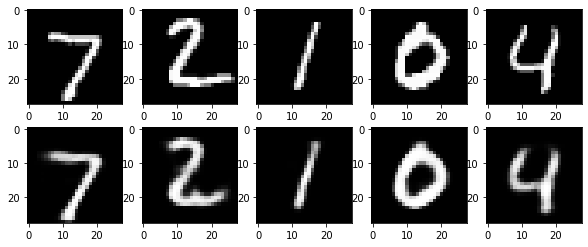

In [14]:
# generate reconstructions
reconstructions = stacked_autoencoder.predict(X_test)

# scale pixels to 0-255
reconstructions *= 255

num = 5
fig = plt.figure(figsize=(12,8))

# show (num) test iamges
for i in range(0,num):
        ax = fig.add_subplot(1, num+1, i+1)
        ax.imshow(X_test[i], cmap='gray')

# show (num) reconstructed images
for i in range(0,num):
        ax = fig.add_subplot(2, num+1, i+num+2)
        ax.imshow(reconstructions[i], cmap='gray')

plt.show()


As we can see it is able to reproduce the images quite well, with only a little bit of noise. However, this noise would liekly increase a lot with more complex images - for that a more complex model will be needed.

### Visualisations with Autoencoders

Autoencoding is generally no better than other common dimensionality reduction algorithms, but it is able to work with a lot of data with high dimensionality. This means it can be useful for visualising high-dimension data by reducing it down to a smaller dimension then using another dimensionality reduction algorithm to reduce it to 2 dimensions for visualisation.

We shall use the current model to reduce MNIST down to 30 dimesnions and then use t-SNE to reduce to 2 dimensions for visualisation:

In [16]:
tsne = TSNE()

X_test_30 = stacked_encoder.predict(X_test)
X_test_2  = tsne.fit_transform(X_test_30)

Now the dimensions have been reduced, we can visualise as a 2D scatter plot:

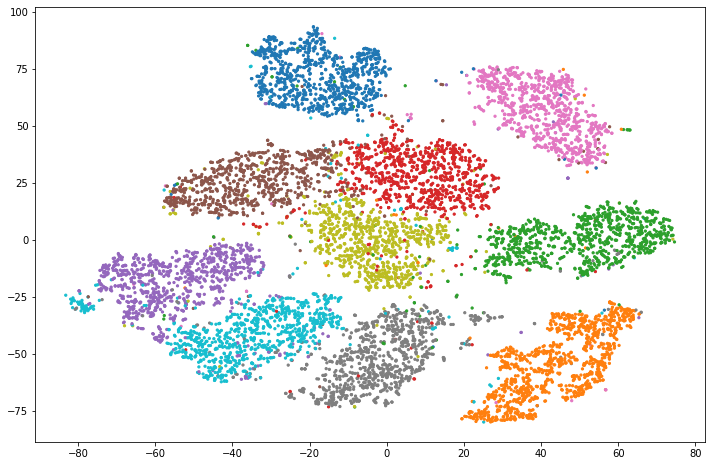

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(X_test_2[:,0], X_test_2[:,1], c=y_test, cmap="tab10", s=5, alpha=1)

plt.show()